# Using Clustering Features Again

using output of 2020_10_31_clustering_on_unique_word_embedings and based on 2020_10_19_further_svm_tuning

## Imports and preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
test_dset_df = pd.read_csv("2020_10_19_test_dset_df_nostem_nostoprem.csv")
train_dset_df["preprocessed_joined"].fillna("", inplace=True)
test_dset_df["preprocessed_joined"].fillna("", inplace=True)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_dset_df["preprocessed_joined"])
sparse_train_x = vectorizer.transform(train_dset_df["preprocessed_joined"])
sparse_test_x  = vectorizer.transform(test_dset_df["preprocessed_joined"])
train_dset_y = train_dset_df["target"].to_numpy()



## Adding the clustering features

In [2]:
N_CLUSTERS = 100 
TRAIN_N_DATA_POINTS = sparse_train_x.shape[0]

In [3]:
CLUSTERS_FOLDER = "./outputs/2020_11_3_agglo_groups/"
FILE_STRING = "2020_11_3_agglo_group_"

In [4]:
group_strings = []
for i in range(100):
    with open(CLUSTERS_FOLDER + FILE_STRING + str(i) +".txt") as file_handler:
        group_strings.append(set([word[:-1] for word in file_handler.readlines()]))


In [5]:
print(group_strings[-1])

{'corroborating', 'indicated', 'official', 'heard', 'diplomats', 'documentation', 'proof', 'acknowledged', 'mention', 'memos', 'told', 'answering', 'correction', 'subject', 'talk', 'interview', 'newspaper', 'irrefutable', 'question', 'speaking', 'suggestions', 'verify', 'pentagon', 'relating', 'xinhua', 'indications', 'comment', 'unclear', 'newspapers', 'wikipedia', 'interpret', 'contrary', 'guardian', 'detail', 'changing', 'showed', 'alibi', 'advice', 'issue', 'clearly', 'editorials', 'embassy', 'asked', 'transcript', 'contradict', 'credible', 'concerning', 'reasoned', 'verbatim', 'indicate', 'noted', 'reflected', 'explain', 'stance', 'letter', 'reported', 'profoundly', 'briefing', 'ministry', 'interpreted', 'concerned', 'informed', 'asking', 'memo', 'phone', 'conversations', 'incontrovertible', 'speakers', 'writing', 'disclosure', 'suggests', 'unidentified', 'anonymity', 'legal', 'reprint', 'suggestion', 'contradicts', 'detailed', 'opinions', 'opinion', 'column', 'absolutely', 'colum

In [6]:
extra_features = np.zeros((TRAIN_N_DATA_POINTS, N_CLUSTERS))

In [7]:
train_dset_df.head()

,qid,target,preprocessed_joined
0,6f47b0f60633c2056455,0,how can i reply to this comment india be poor ...
1,d49b3966070b27bf07fc,0,what do they use for transportation in ancient...
2,6d5faa49380557c8ca7b,0,what be the most important provision of obama ...
3,cebea75faa47388edcf5,0,at what age do most finns master english today
4,2a7b76a679cadb0a016e,0,what be cheap place to live in india for one m...


In [8]:
for i in tqdm(range(100)):
    for j in (range(len(train_dset_df))):
        sentence_list = train_dset_df["preprocessed_joined"][j].split()
        for word in sentence_list:
            if word in group_strings[i]:
                extra_features[j][i] += 1


100%|██████████| 100/100 [08:20<00:00,  5.00s/it]


## Grouping and training

Now, we divide the training dataset into multiple groups. **A question may belong to more than one group**.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

In [21]:
models = [LinearSVC(penalty="l2",dual=True,class_weight={0:1,1:3.35}, C=0.0125) for i in range(N_CLUSTERS)]
train_dsets = [(sparse_train_x[extra_features[:,i] > 0], train_dset_y[extra_features[:,i] > 0]) for i in range(N_CLUSTERS)]
f1_scores = []
for model, train_dset in tqdm(zip(models, train_dsets)):
    x = train_dset[0]
    y = train_dset[1]
    model.fit(x, y)
    yhat = model.predict(x)
    curr_f1_score = f1_score(y, yhat)
    f1_scores.append(curr_f1_score)

100it [00:26,  3.77it/s]


In [22]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

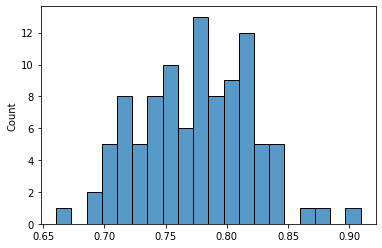

In [24]:
sns.histplot(f1_scores, bins=20)

The training set errors are somewhat encouraging. However, there is a great risk of overfitting in this method here.

## Training with some validation

In [66]:
models = [LinearSVC(penalty="l2",dual=True,class_weight={0:1,1:3.35}, C=0.006) for i in range(N_CLUSTERS)]
train_dsets = [(sparse_train_x[extra_features[:,i] > 0], train_dset_y[extra_features[:,i] > 0]) for i in range(N_CLUSTERS)]
train_f1_scores = []
test_f1_scores = []
for model, train_dset in tqdm(zip(models, train_dsets)):
    x = train_dset[0]
    y = train_dset[1]
    train_x = x[::2,:]
    train_y = y[::2]
    test_x =  x[1::2,:]
    test_y =  y[1::2]
    model.fit(train_x, train_y)
    train_yhat = model.predict(train_x)
    train_f1_score = f1_score(train_y, train_yhat)
    train_f1_scores.append(train_f1_score)
    test_yhat = model.predict(test_x)
    test_f1_score = f1_score(test_y, test_yhat)
    test_f1_scores.append(test_f1_score)

100it [00:07, 13.10it/s]


0.7213370905168397

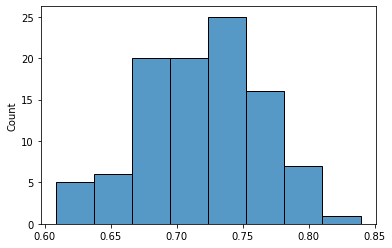

In [67]:
sns.histplot(train_f1_scores)
np.median(train_f1_scores)

0.5068414065202554

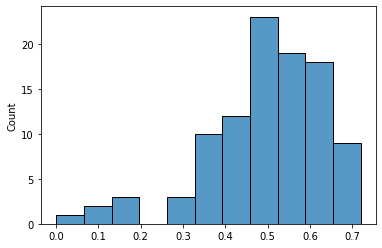

In [68]:
sns.histplot(test_f1_scores)
np.median(test_f1_scores)

In [69]:
import matplotlib.pyplot as plt

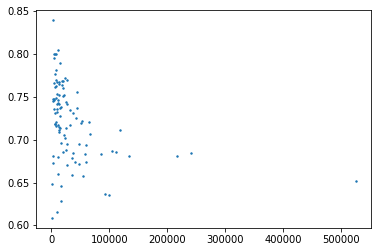

In [70]:
plt.scatter([a[0].shape[0] for a in train_dsets], train_f1_scores, s=2)

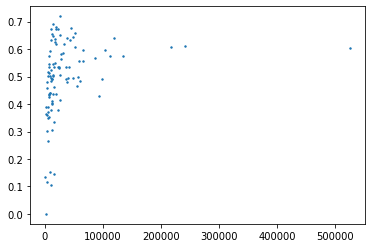

In [71]:
plt.scatter([a[0].shape[0] for a in train_dsets], test_f1_scores, s=2)

In [40]:
np.mean(test_f1_scores)

0.4008599964173974